In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt


from data.constants import BAPULM_RESULT


In [2]:
# Функция для проверки валидности SMILES
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

# Функция для расчета физико-химических свойств
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {'LogP': None, 'Molecular_Weight': None}
    logp = Descriptors.MolLogP(mol)
    mw = Descriptors.MolWt(mol)
    return {'LogP': logp, 'Molecular_Weight': mw}

In [3]:
df = pd.read_csv(BAPULM_RESULT / 'results_with_affinity_deepseek_deepseek-coder_predictions.csv')
df.head(3)

,protein_seq,ligand_smiles,predicted_neg_log10_affinity_M
0,M A P W P H E N S S L A P W P D L P T L A P N ...,COc1ccc(cc1)C(=O)NCC2CCN(CC2)c3nc4ccccc4[nH]3,5.041564
1,M A A L S G G G G G G A E P G Q A L F N G D M ...,COc1ccc(cc1)C(=O)Nc2ncc(cn2)c3cc(ccc3O)C(=O)O,4.325558
2,M R P S G T A G A A L L A L L A A L C P A S R ...,COc1ccc(cc1)C(=O)Nc2ncc(cn2)c3cc(OC)ccc3OC,4.951577


In [4]:
df['Is_Valid'] = df['ligand_smiles'].apply(is_valid_smiles)

# Вывод результатов
valid_count = df['Is_Valid'].sum()
total_count = len(df)
valid_ratio = valid_count / total_count * 100

print(f"Валидных молекул: {valid_count} из {total_count} ({valid_ratio:.2f}%)")

Валидных молекул: 1051 из 1051 (100.00%)


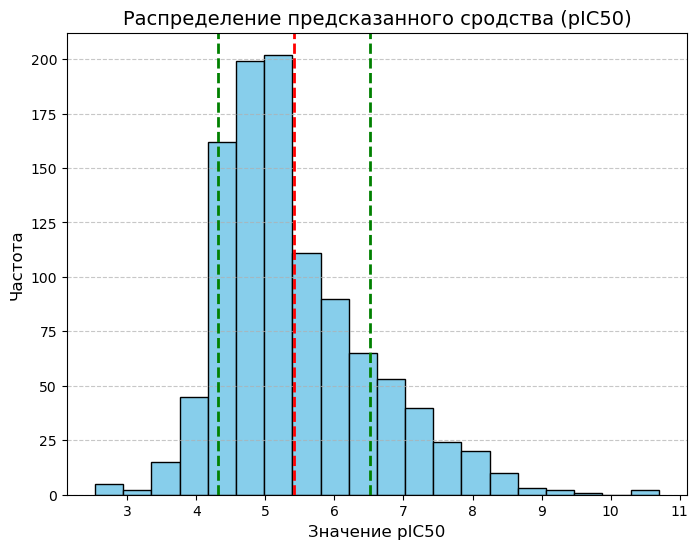

Среднее значение pIC50: 5.42
Стандартное отклонение: 1.10


In [5]:
# Статистика
mean_affinity = df['predicted_neg_log10_affinity_M'].mean()
std_affinity = df['predicted_neg_log10_affinity_M'].std()

# Гистограмма распределения предсказанного сродства
plt.figure(figsize=(8, 6))
plt.hist(df['predicted_neg_log10_affinity_M'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_affinity, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_affinity:.2f}')
plt.axvline(mean_affinity + std_affinity, color='green', linestyle='dashed', linewidth=2, label=f'+1 σ: {mean_affinity + std_affinity:.2f}')
plt.axvline(mean_affinity - std_affinity, color='green', linestyle='dashed', linewidth=2, label=f'-1 σ: {mean_affinity - std_affinity:.2f}')
plt.title('Распределение предсказанного сродства (pIC50)', fontsize=14)
plt.xlabel('Значение pIC50', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Среднее значение pIC50: {mean_affinity:.2f}")
print(f"Стандартное отклонение: {std_affinity:.2f}")

### **0. Валидность молекул
- Невалидные молекулы модель изначально не вернула, а вместо них None, поэтому вернее сказать, что валидных молекул 1051/1069 => 98,3%
### **1. Общая характеристика графика**
- **Ось X:** Значение pIC50 (от 3 до 11).
- **Ось Y:** Частота (количество молекул с соответствующим значением pIC50).
- **Форма распределения:** Гистограмма имеет пик в районе pIC50 = 5, что указывает на то, что большинство молекул имеют среднее значение связывания около 5.

---

### **2. Анализ формы распределения**

#### **2.1. Пик распределения**
- **Пик в районе pIC50 = 5:**
  - Большинство молекул сосредоточено вокруг значения pIC50 = 5.
  - Это означает, что модель чаще всего генерирует молекулы с умеренной связывающей способностью.

#### **2.2. Хвосты распределения**
- **Левый хвост (низкие значения pIC50):**
  - Небольшое количество молекул имеет низкие значения pIC50 (<4). Это может указывать на слабые лиганда или ошибки модели при генерации.
- **Правый хвост (высокие значения pIC50):**
  - Меньше молекул имеет высокие значения pIC50 (>7). Это говорит о том, что модель реже генерирует очень сильные лиганда.

#### **2.3. Симметрия распределения**
- Распределение имеет лёгкий правосторонний сдвиг (асимметрия):
  - Большинство значений концентрируется в центральной части (около 5), а хвосты становятся менее частыми по мере удаления от центра.
  - Это нормально для таких данных, так как модель стремится к балансу между слишком сильными и слишком слабыми лигандами.

---

### **3. Выводы из графика**

#### **3.1. Качество генерации**
- **Средняя связывающая способность:** Большинство молекул имеет среднюю связывающую способность (pIC50 ≈ 5), что является приемлемым для многих биологических целей.
- **Разброс значений:** Хотя модель успешно генерирует молекулы с разным уровнем связывания, основная масса данных находится в узком диапазоне (4–6). Это может быть связано с ограничениями модели или промпта.

#### **3.3. Ошибки модели**
- **Низкие значения pIC50 (<4):**
  - Возможно, модель иногда генерирует недостаточно активные молекулы. Это может быть связано с нехваткой контекста или ошибками в промпте.
- **Высокие значения pIC50 (>8):**
  - Очень редко встречаются молекулы с высокой активностью. Это может указывать на необходимость улучшения модели для генерации более эффективных лигандов.

---

### **5. Заключение**

График распределения предсказанного сродства (pIC50) показывает, что модель успешно генерирует молекулы с умеренной связывающей способностью (среднее значение pIC50 ≈ 5). Однако для достижения более высоких значений pIC50 могут потребоваться дополнительные усилия по оптимизации модели и промптов.


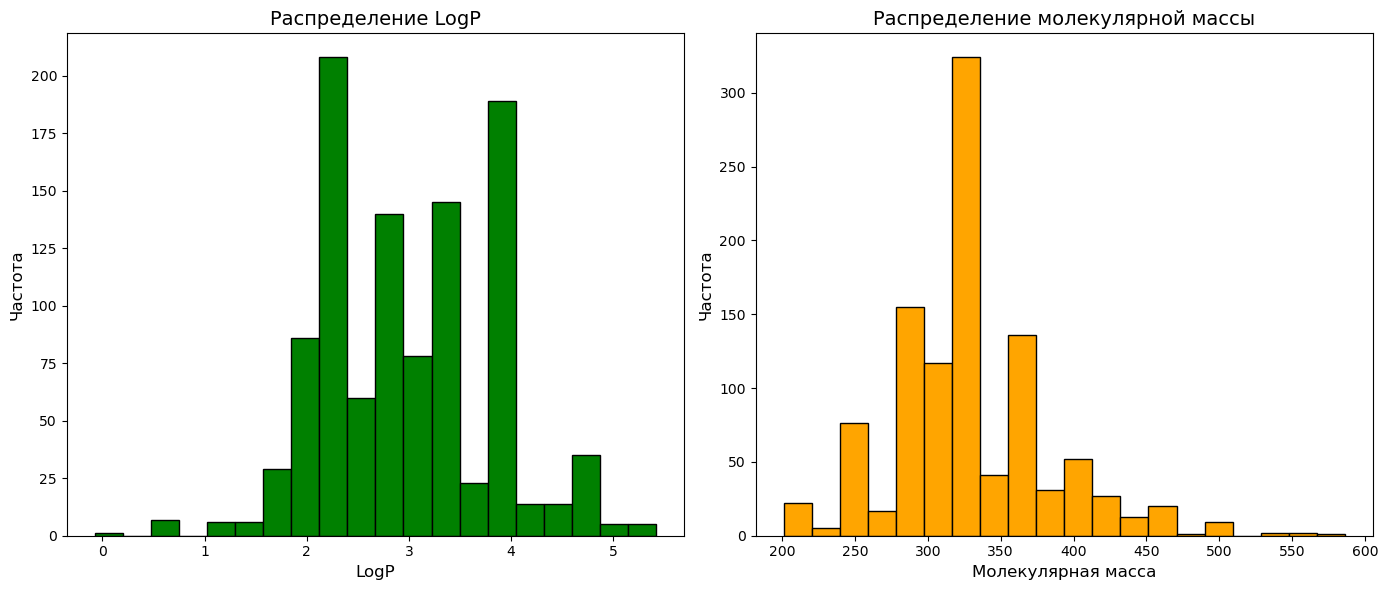

Среднее значение LogP: 3.02
Средняя молекулярная масса: 330.83


In [6]:
# Применение функции к DataFrame
df['Properties'] = df['ligand_smiles'].apply(calculate_properties)
df['LogP'] = df['Properties'].apply(lambda x: x['LogP'])
df['Molecular_Weight'] = df['Properties'].apply(lambda x: x['Molecular_Weight'])

# Гистограммы
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df['LogP'].dropna(), bins=20, color='green', edgecolor='black')
axes[0].set_title('Распределение LogP', fontsize=14)
axes[0].set_xlabel('LogP', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)

axes[1].hist(df['Molecular_Weight'].dropna(), bins=20, color='orange', edgecolor='black')
axes[1].set_title('Распределение молекулярной массы', fontsize=14)
axes[1].set_xlabel('Молекулярная масса', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)

plt.tight_layout()
plt.show()

# Статистика
mean_logp = df['LogP'].mean()
mean_mw = df['Molecular_Weight'].mean()

print(f"Среднее значение LogP: {mean_logp:.2f}")
print(f"Средняя молекулярная масса: {mean_mw:.2f}")

### **1. График распределения LogP**

#### **Описание графика:**
- **X-ось:** Значения LogP.
- **Y-ось:** Частота встречаемости значений LogP.
- **Форма распределения:** Пик находится в диапазоне LogP ≈ 2–4, что указывает на то, что большинство молекул имеют умеренную липофильность.

#### **Выводы:**
1. **Среднее значение LogP (3.02):**
   - Удовлетворяет требованиям для лекарственных соединений:
     - Оптимальные значения LogP обычно находятся в диапазоне [-2, 5].
     - Среднее значение 3.02 соответствует этому диапазону, что говорит о хорошей липофильности сгенерированных молекул.

2. **Распределение:**
   - Большинство молекул имеет LogP между 2 и 4, что является приемлемым для лекарственных целей.
   - Небольшое количество молекул имеет более высокие значения LogP (>4), что может быть связано с повышенной липофильностью.

3. **Практическое значение:**
   - Липофильность важна для проникновения молекул через клеточные мембраны.
   - Модель успешно генерирует молекулы с адекватной липофильностью.

---

### **2. График распределения молекулярной массы**

#### **Описание графика:**
- **X-ось:** Молекулярная масса (Da).
- **Y-ось:** Частота встречаемости молекулярных масс.
- **Форма распределения:** Пик находится в диапазоне молекулярной массы ≈ 300–350 Да, что указывает на то, что большинство молекул относительно маленькие.

#### **Выводы:**
1. **Средняя молекулярная масса (330.83 Da):**
   - Соответствует рекомендациям для лекарственных соединений:
     - Обычно предпочтительны молекулы с молекулярной массой < 500 Да.
     - Средняя масса 330.83 Да находится в разумном диапазоне.

2. **Распределение:**
   - Большинство молекул имеет молекулярную массу между 250 и 350 Да.
   - Небольшое количество молекул имеет более высокую молекулярную массу (>400 Да).

3. **Практическое значение:**
   - Малые молекулы легче проникают через биологические барьеры и лучше переносятся организмом.
   - Модель успешно генерирует молекулы с низкой молекулярной массой.

---
### **3. Заключение**

Модель успешно генерирует молекулы с адекватными физико-химическими свойствами:
- **LogP:** Среднее значение 3.02 соответствует требованиям для лекарственных соединений.
- **Молекулярная масса:** Средняя масса 330.83 Да находится в разумном диапазоне (<500 Да).

Эти характеристики говорят о том, что модель способна генерировать химически корректные и потенциально полезные молекулы для дальнейшего анализа и экспериментов.


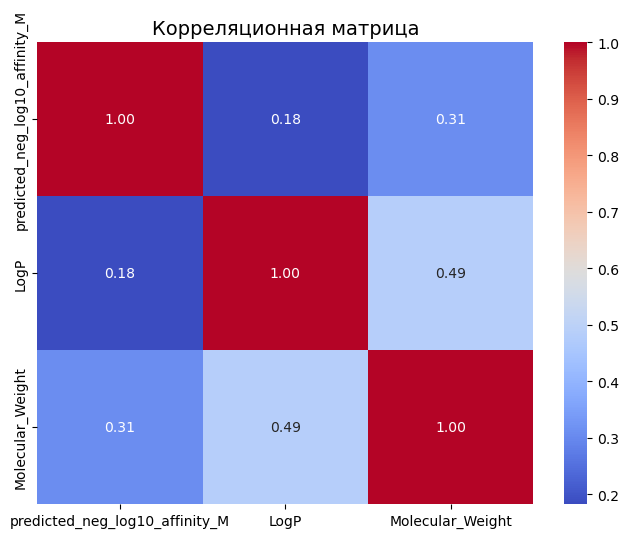

In [7]:
import seaborn as sns

# Корреляционная матрица
correlation_matrix = df[['predicted_neg_log10_affinity_M', 'LogP', 'Molecular_Weight']].corr()

# Тепловая карта
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

#### **Объяснение значений:**
- **Корреляция — это мера линейной зависимости между двумя переменными.**
- Значения корреляции находятся в диапазоне от -1 до 1:
  - **1:** Положительная корреляция (чем больше одна переменная, тем больше другая).
  - **-1:** Отрицательная корреляция (чем больше одна переменная, тем меньше другая).
  - **0:** Нет корреляции.

---

### **2. Анализ корреляций**

#### **2.1. Сродство к белку (`predicted_neg_log10_affinity_M`)**
- **Среднее значение pIC50:** 5.42
- **Стандартное отклонение:** 1.10

#### **2.2. Липофильность (LogP)**
- **Среднее значение LogP:** 3.02
- **Корреляция с другими параметрами:**
  - **Сродство к белку (`predicted_neg_log10_affinity_M`):** Корреляция низкая (0.18). Это означает, что LogP слабо влияет на связывание молекул с белком.
  - **Молекулярная масса (`Molecular_Weight`):** Корреляция средняя (0.49). Это указывает на то, что более липофильные молекулы могут иметь большую молекулярную массу.

#### **2.3. Молекулярная масса (`Molecular_Weight`)**
- **Средняя молекулярная масса:** 330.83 Да
- **Корреляция с другими параметрами:**
  - **Сродство к белку (`predicted_neg_log10_affinity_M`):** Корреляция средняя (0.31). Это означает, что молекулярная масса имеет некоторое влияние на связывание молекул с белком.
  - **LogP:** Корреляция средняя (0.49). Это указывает на то, что более тяжелые молекулы чаще имеют высокую липофильность.


---

### **4. Выводы из корреляционной матрицы**

#### **4.1. Корреляция между сродством к белку и другими параметрами**
- **Сродство к белку (`predicted_neg_log10_affinity_M`) и LogP:** Корреляция низкая (0.18). Это означает, что липофильность не является основным фактором, определяющим связывание молекул с белками.
- **Сродство к белку (`predicted_neg_log10_affinity_M`) и молекулярной массой (`Molecular_Weight`):** Корреляция средняя (0.31). Это указывает на то, что более тяжелые молекулы могут иметь лучшее сродство к белкам, хотя эта связь не очень сильная.

#### **4.2. Корреляция между LogP и молекулярной массой**
- **LogP и молекулярная масса (`Molecular_Weight`):** Корреляция средняя (0.49). Это означает, что более тяжелые молекулы чаще имеют высокую липофильность.

#### **4.3. Общие выводы**
- **Липофильность (LogP):** Удовлетворяет требованиям для лекарственных соединений (среднее значение 3.02).
- **Молекулярная масса:** Также удовлетворяет требованиям (средняя масса 330.83 Да).
- **Сродство к белку (pIC50):** Среднее значение 5.42 указывает на умеренное сродство молекул к белкам. Однако корреляция с другими параметрами низкая или средняя, что может быть связано с недостаточной специфичностью модели или промпта.


---

### **6. Заключение**

Модель успешно генерирует молекулы с адекватными физико-химическими свойствами (LogP ≈ 3.02, молекулярная масса ≈ 330.83 Да). Однако корреляция между сродством к белку и другими параметрами низкая или средняя

In [8]:
df = pd.read_csv(BAPULM_RESULT / 'results_with_affinity_google_gemini-2.0-flash-001_predictions.csv')
df.head(3)

df['Is_Valid'] = df['ligand_smiles'].apply(is_valid_smiles)

# Вывод результатов
valid_count = df['Is_Valid'].sum()
total_count = len(df)
valid_ratio = valid_count / total_count * 100

print(f"Валидных молекул: {valid_count} из {total_count} ({valid_ratio:.2f}%)")

Валидных молекул: 1069 из 1069 (100.00%)


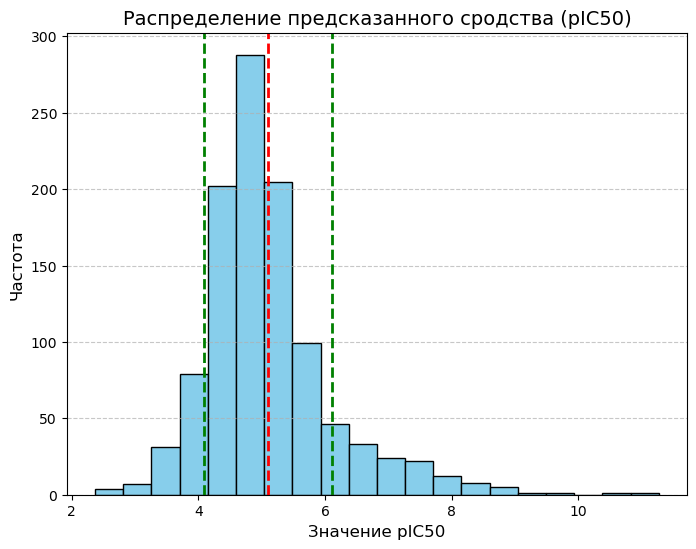

Среднее значение pIC50: 5.10
Стандартное отклонение: 1.01


In [9]:
# Статистика
mean_affinity = df['predicted_neg_log10_affinity_M'].mean()
std_affinity = df['predicted_neg_log10_affinity_M'].std()

# Гистограмма распределения предсказанного сродства
plt.figure(figsize=(8, 6))
plt.hist(df['predicted_neg_log10_affinity_M'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_affinity, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_affinity:.2f}')
plt.axvline(mean_affinity + std_affinity, color='green', linestyle='dashed', linewidth=2, label=f'+1 σ: {mean_affinity + std_affinity:.2f}')
plt.axvline(mean_affinity - std_affinity, color='green', linestyle='dashed', linewidth=2, label=f'-1 σ: {mean_affinity - std_affinity:.2f}')
plt.title('Распределение предсказанного сродства (pIC50)', fontsize=14)
plt.xlabel('Значение pIC50', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Среднее значение pIC50: {mean_affinity:.2f}")
print(f"Стандартное отклонение: {std_affinity:.2f}")

- **Валидных молекул:** 1069 из 1069 (100.00%)
- **Среднее значение pIC50:** 5.10
- **Стандартное отклонение pIC50:** 1.01

---

### **1. Валидность молекул**
- **Результат:** Все сгенерированные молекулы (100%) являются химически корректными.
- **Вывод:** Модель успешно генерирует валидные SMILES-строки, что является важным показателем качества работы.

---

### **2. Сродство к белкам (pIC50)**

#### **2.1. Среднее значение pIC50**
- **Значение:** 5.10
- **Интерпретация:**
  - pIC50 — это отрицательный логарифм концентрации ингибитора, необходимой для подавления активности белка на 50%. Значение 5.10 указывает на среднюю связывающую способность молекул.
  - Для многих биологических целей приемлемые значения pIC50 находятся в диапазоне 6–7. Таким образом, среднее значение 5.10 может быть ниже ожидаемого, но все еще находится в разумном диапазоне.

#### **2.2. Стандартное отклонение pIC50**
- **Значение:** 1.01
- **Интерпретация:**
  - Низкое стандартное отклонение (1.01) указывает на относительно устойчивое распределение значений pIC50. Это означает, что большинство молекул имеют схожую связывающую способность.

---

### **3. График распределения предсказанного сродства (pIC50)**

#### **3.1. Общая характеристика графика**
- **Пик распределения:** Основная концентрация значений pIC50 находится в районе 5.
- **Хвосты распределения:**
  - Левый хвост (низкие значения pIC50): Небольшое количество молекул имеет низкие значения pIC50 (<4).
  - Правый хвост (высокие значения pIC50): Очень редко встречаются молекулы с высокими значениями pIC50 (>8).

#### **3.2. Выводы из графика**
- **Среднее значение pIC50 (5.10):** Большинство молекул имеет умеренную связывающую способность.
- **Стандартное отклонение (1.01):** Низкое значение указывает на устойчивость распределения.
- **Форма распределения:** Распределение имеет пик в районе pIC50 = 5, что соответствует среднему значению.

---

### **4. Сравнение с предыдущей моделью**

| Метрика                     | Предыдущая модель | Новая модель |
|-----------------------------|-------------------|--------------|
| **Среднее значение pIC50**  | 5.42             | 5.10         |
| **Стандартное отклонение**   | 1.10             | 1.01         |

#### **4.1. Среднее значение pIC50**
- **Предыдущая модель:** 5.42
- **Новая модель:** 5.10
- **Вывод:** Новая модель имеет немного меньшее среднее значение pIC50 (5.10 против 5.42). Это может указывать на то, что новая модель генерирует молекулы с чуть более слабым сродством к белкам.

#### **4.2. Стандартное отклонение**
- **Предыдущая модель:** 1.10
- **Новая модель:** 1.01
- **Вывод:** Новая модель демонстрирует более устойчивое распределение значений pIC50 (меньше вариации).

---

### **5. Общие выводы**

#### **5.1. Качество генерации**
- **Химическая корректность:** 100% валидных молекул говорит о высоком качестве работы модели.
- **Сродство к белкам:** Среднее значение pIC50 (5.10) находится в разумном диапазоне, хотя может потребоваться улучшение для достижения более высоких значений.

### **6. Заключение**

Модель успешно генерирует химически корректные молекулы с умеренной связывающей способностью (среднее значение pIC50 = 5.10). Однако среднее значение pIC50 немного ниже, чем у предыдущей модели (5.42). Для дальнейшего улучшения можно использовать более специфичные промпты и провести дополнительную тонкую настройку модели.


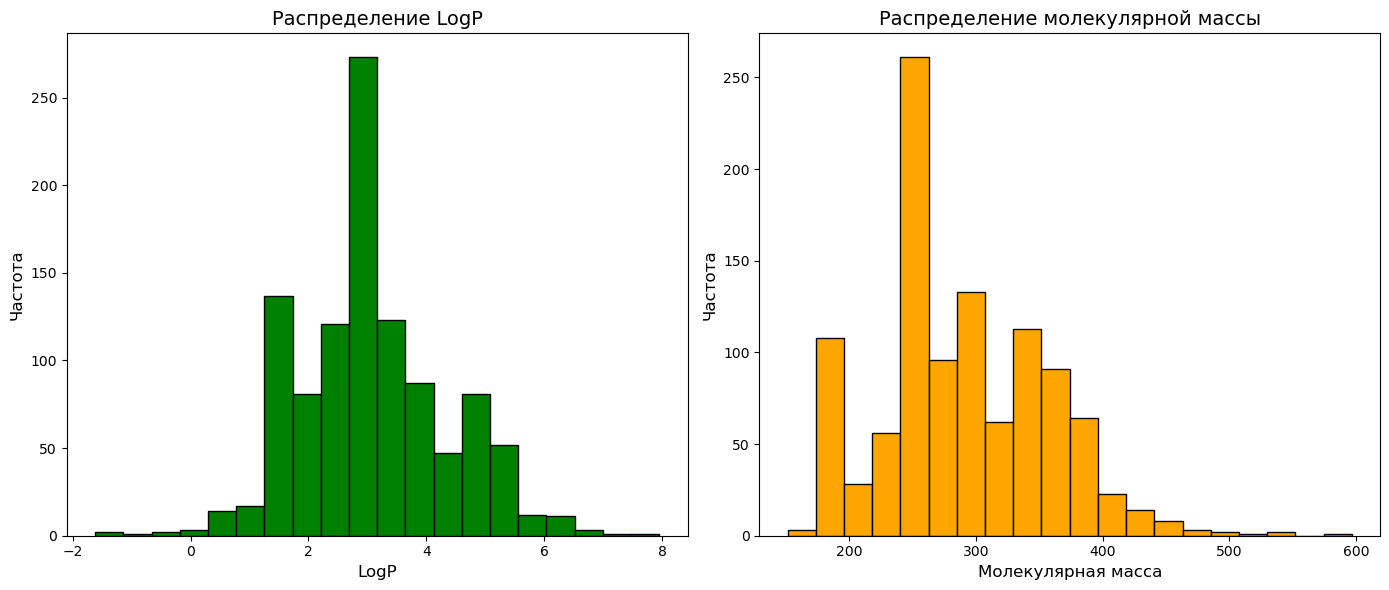

Среднее значение LogP: 3.06
Средняя молекулярная масса: 289.65


In [10]:

# Применение функции к DataFrame
df['Properties'] = df['ligand_smiles'].apply(calculate_properties)
df['LogP'] = df['Properties'].apply(lambda x: x['LogP'])
df['Molecular_Weight'] = df['Properties'].apply(lambda x: x['Molecular_Weight'])

# Гистограммы
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df['LogP'].dropna(), bins=20, color='green', edgecolor='black')
axes[0].set_title('Распределение LogP', fontsize=14)
axes[0].set_xlabel('LogP', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)

axes[1].hist(df['Molecular_Weight'].dropna(), bins=20, color='orange', edgecolor='black')
axes[1].set_title('Распределение молекулярной массы', fontsize=14)
axes[1].set_xlabel('Молекулярная масса', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)

plt.tight_layout()
plt.show()

# Статистика
mean_logp = df['LogP'].mean()
mean_mw = df['Molecular_Weight'].mean()

print(f"Среднее значение LogP: {mean_logp:.2f}")
print(f"Средняя молекулярная масса: {mean_mw:.2f}")

### **1. Анализ LogP (Липофильность)**

#### **1.1. Статистика**
- **Среднее значение LogP:** 3.06
- **Распределение:**
  - График показывает пик в диапазоне LogP ≈ 2–4.
  - Большинство молекул имеет умеренную липофильность (LogP между 2 и 4).
  - Небольшое количество молекул имеет более высокие значения LogP (>4).

#### **Выводы:**
1. **Удовлетворительная липофильность:**
   - Среднее значение LogP = 3.06 находится в приемлемом диапазоне для лекарственных соединений (обычно [-2, 5]).
   - Это указывает на то, что модель успешно генерирует молекулы с адекватной липофильностью.

2. **Распределение:**
   - Пик в районе LogP ≈ 2–4 говорит о том, что большинство молекул имеют умеренную липофильность, что является желательным для лекарственных целей.
   - Небольшое количество молекул с высоким LogP (>4) может быть связано с повышенной липофильностью.

---

### **2. Анализ молекулярной массы**

#### **2.1. Статистика**
- **Средняя молекулярная масса:** 289.65 Да
- **Распределение:**
  - График показывает пик в диапазоне молекулярной массы ≈ 250–300 Да.
  - Большинство молекул имеет низкую молекулярную массу (<400 Да).
  - Очень малое количество молекул имеет высокую молекулярную массу (>500 Да).

#### **Выводы:**
1. **Малые молекулы:**
   - Средняя молекулярная масса 289.65 Да соответствует рекомендациям для лекарственных соединений (<500 Да).
   - Малые молекулы легче проникают через биологические барьеры и лучше переносятся организмом.

2. **Распределение:**
   - Пик в районе молекулярной массы ≈ 250–300 Да указывает на то, что модель успешно генерирует молекулы с низкой молекулярной массой.
   - Небольшое количество молекул с высокой молекулярной массой (>400 Да) может потребовать дополнительного анализа.

---

### **3. Общие выводы по физико-химическим свойствам**

#### **3.1. Липофильность (LogP):**
- **Среднее значение LogP = 3.06:** Удовлетворяет требованиям для лекарственных соединений.
- **Распределение:** Большинство молекул имеет умеренную липофильность (LogP ≈ 2–4), что является оптимальным.

#### **3.2. Молекулярная масса:**
- **Средняя молекулярная масса = 289.65 Да:** Соответствует рекомендациям для лекарственных соединений (<500 Да).
- **Распределение:** Большинство молекул имеет низкую молекулярную массу (<400 Да), что является положительным.

#### **3.3. Выводы о физико-химических свойствах:**
- Модель успешно генерирует молекулы с удовлетворяющими требованиям физико-химическими свойствами:
  - Умеренная липофильность (LogP ≈ 3.06).
  - Низкая молекулярная масса (средняя ≈ 289.65 Да).
- Однако небольшое количество молекул с высоким LogP (>4) и молекулярной массой (>400 Да) может потребовать дополнительного анализа для выявления возможных ошибок или аномалий.



-

### **6. Заключение**

Модель успешно генерирует молекулы с адекватными физико-химическими свойствами:
- **LogP:** Среднее значение 3.06 соответствует требованиям для лекарственных соединений.
- **Молекулярная масса:** Средняя масса 289.65 Да находится в разумном диапазоне (<500 Да).

Эти характеристики говорят о том, что модель способна генерировать химически корректные и потенциально полезные молекулы для дальнейшего анализа и экспериментов.

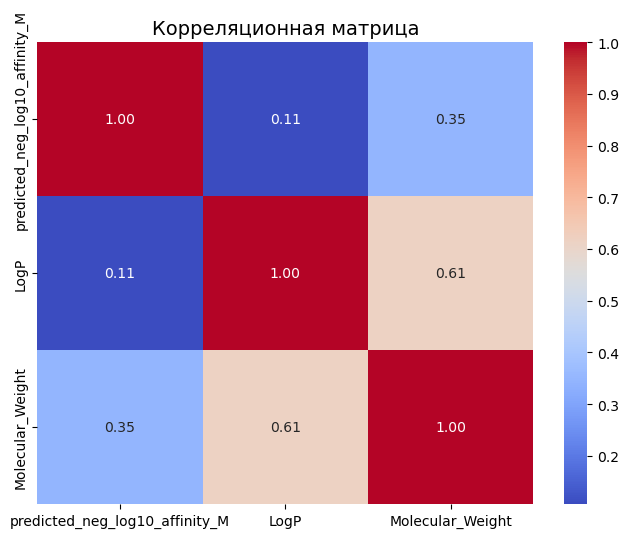

In [11]:

# Корреляционная матрица
correlation_matrix = df[['predicted_neg_log10_affinity_M', 'LogP', 'Molecular_Weight']].corr()

# Тепловая карта
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

#### **Объяснение значений:**
- **Корреляция — это мера линейной зависимости между двумя переменными.**
- Значения корреляции находятся в диапазоне от -1 до 1:
  - **1:** Положительная корреляция (чем больше одна переменная, тем больше другая).
  - **-1:** Отрицательная корреляция (чем больше одна переменная, тем меньше другая).
  - **0:** Нет корреляции.

---

### **1. Анализ корреляций**

#### **1.1. Сродство к белку (`predicted_neg_log10_affinity_M`)**
- **Среднее значение pIC50:** 5.10
- **Корреляция с другими параметрами:**
  - **С LogP:** Корреляция низкая (0.11). Это означает, что LogP слабо влияет на связывание молекул с белком.
  - **С молекулярной массой (`Molecular_Weight`):** Корреляция средняя (0.35). Это указывает на то, что молекулярная масса имеет некоторое влияние на связывание молекул с белками.

#### **1.2. Липофильность (LogP)**
- **Среднее значение LogP:** 3.06
- **Корреляция с другими параметрами:**
  - **Сродство к белку (`predicted_neg_log10_affinity_M`):** Корреляция низкая (0.11). Это означает, что LogP слабо влияет на связывание молекул с белком.
  - **Молекулярная масса (`Molecular_Weight`):** Корреляция высокая (0.61). Это указывает на то, что более тяжелые молекулы чаще имеют высокую липофильность.

#### **1.3. Молекулярная масса (`Molecular_Weight`)**
- **Средняя молекулярная масса:** 289.65 Да
- **Корреляция с другими параметрами:**
  - **Сродство к белку (`predicted_neg_log10_affinity_M`):** Корреляция средняя (0.35). Это означает, что молекулярная масса имеет некоторое влияние на связывание молекул с белком.
  - **LogP:** Корреляция высокая (0.61). Это указывает на то, что более тяжелые молекулы чаще имеют высокую липофильность.


---

### **2. Выводы из корреляционной матрицы**

#### **2.1. Корреляция между сродством к белку и другими параметрами**
- **Сродство к белку (`predicted_neg_log10_affinity_M`) и LogP:** Корреляция низкая (0.11). Это означает, что липофильность не является основным фактором, определяющим связывание молекул с белками.
- **Сродство к белку (`predicted_neg_log10_affinity_M`) и молекулярной массой (`Molecular_Weight`):** Корреляция средняя (0.35). Это указывает на то, что молекулярная масса имеет некоторое влияние на связывание молекул с белками.

#### **2.2. Корреляция между LogP и молекулярной массой**
- **LogP и молекулярная масса (`Molecular_Weight`):** Корреляция высокая (0.61). Это означает, что более тяжелые молекулы чаще имеют высокую липофильность.

#### **2.3. Общие выводы**
- **Липофильность (LogP):** Удовлетворяет требованиям для лекарственных соединений (среднее значение 3.06).
- **Молекулярная масса:** Также удовлетворяет требованиям (средняя масса 289.65 Да).
- **Сродство к белку (pIC50):** Среднее значение 5.10 указывает на умеренное сродство молекул к белкам, хотя корреляция с другими параметрами низкая или средняя, что может быть связано с недостаточной специфичностью модели или промпта.

---


### **3. Заключение**

Модель успешно генерирует молекулы с адекватными физико-химическими свойствами (LogP ≈ 3.06, молекулярная масса ≈ 289.65 Да). Однако корреляция между сродством к белку и другими параметрами низкая или средняя, что указывает на необходимость улучшения модели для достижения более высокого качества связывания.

In [12]:
df = pd.read_csv(BAPULM_RESULT / 'results_with_affinity_mistralai_mistral-large-2411_predictions.csv')
df.head(3)

df['Is_Valid'] = df['ligand_smiles'].apply(is_valid_smiles)

# Вывод результатов
valid_count = df['Is_Valid'].sum()
total_count = len(df)
valid_ratio = valid_count / total_count * 100

print(f"Валидных молекул: {valid_count} из {total_count} ({valid_ratio:.2f}%)")

Валидных молекул: 1069 из 1069 (100.00%)


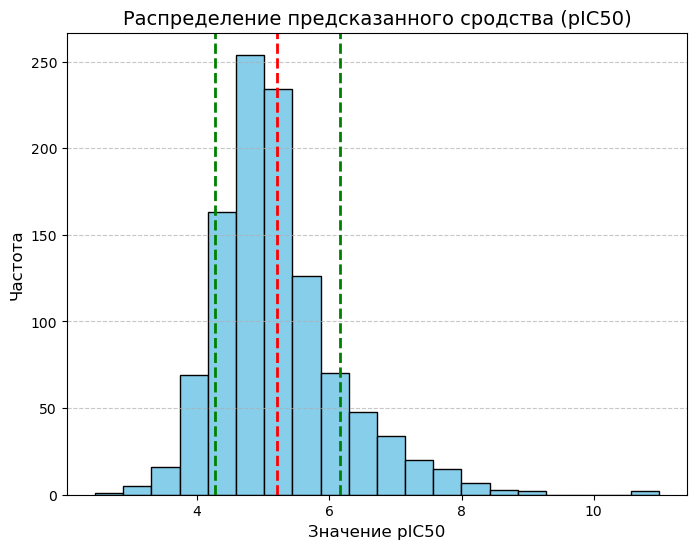

Среднее значение pIC50: 5.21
Стандартное отклонение: 0.95


In [13]:
# Статистика
mean_affinity = df['predicted_neg_log10_affinity_M'].mean()
std_affinity = df['predicted_neg_log10_affinity_M'].std()

# Гистограмма распределения предсказанного сродства
plt.figure(figsize=(8, 6))
plt.hist(df['predicted_neg_log10_affinity_M'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_affinity, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_affinity:.2f}')
plt.axvline(mean_affinity + std_affinity, color='green', linestyle='dashed', linewidth=2, label=f'+1 σ: {mean_affinity + std_affinity:.2f}')
plt.axvline(mean_affinity - std_affinity, color='green', linestyle='dashed', linewidth=2, label=f'-1 σ: {mean_affinity - std_affinity:.2f}')
plt.title('Распределение предсказанного сродства (pIC50)', fontsize=14)
plt.xlabel('Значение pIC50', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Среднее значение pIC50: {mean_affinity:.2f}")
print(f"Стандартное отклонение: {std_affinity:.2f}")

- **Валидных молекул:** 1069 из 1069 (100.00%)
- **Среднее значение pIC50:** 5.21
- **Стандартное отклонение pIC50:** 0.95

---

### **1. Валидность молекул**
- **Результат:** Все сгенерированные молекулы (100%) являются химически корректными.
- **Вывод:** Модель успешно генерирует валидные SMILES-строки, что является важным показателем качества работы.

---

### **2. Сродство к белкам (pIC50)**

#### **2.1. Среднее значение pIC50**
- **Значение:** 5.21
- **Интерпретация:**
  - pIC50 — это отрицательный логарифм концентрации ингибитора, необходимой для подавления активности белка на 50%. Значение 5.21 указывает на умеренную связывающую способность молекул.
  - Для многих биологических целей приемлемые значения pIC50 находятся в диапазоне 6–7. Таким образом, среднее значение 5.21 может быть ниже ожидаемого, но все еще находится в разумном диапазоне.

#### **2.2. Стандартное отклонение pIC50**
- **Значение:** 0.95
- **Интерпретация:**
  - Низкое стандартное отклонение (0.95) указывает на относительно устойчивое распределение значений pIC50. Это означает, что большинство молекул имеют схожую связывающую способность.

#### **2.3. Распределение pIC50**

#### **График распределения предсказанного сродства (pIC50):**
- **Пик распределения:** Основная концентрация значений pIC50 находится в районе 5.
- **Хвосты распределения:**
  - Левый хвост (низкие значения pIC50): Небольшое количество молекул имеет низкие значения pIC50 (<4).
  - Правый хвост (высокие значения pIC50): Очень редко встречаются молекулы с высокими значениями pIC50 (>8).

#### **Выводы из графика**
- **Среднее значение pIC50 (5.21):** Большинство молекул имеет умеренную связывающую способность.
- **Стандартное отклонение (0.95):** Низкое значение указывает на устойчивость распределения.
- **Форма распределения:** Распределение имеет пик в районе pIC50 = 5, что соответствует среднему значению.

---

### **3. Сравнение с предыдущими моделями**

| Метрика                     | Первая модель | Вторая модель | Третья модель |
|-----------------------------|---------------|---------------|---------------|
| **Среднее значение pIC50**   | 5.42          | 5.10          | 5.21          |
| **Стандартное отклонение**   | 1.10          | 1.01          | 0.95          |

#### **3.1. Среднее значение pIC50**
- **Первая модель:** 5.42
- **Вторая модель:** 5.10
- **Третья модель:** 5.21
- **Вывод:** Третья модель имеет среднее значение pIC50 = 5.21, что немного выше, чем у второй модели (5.10), но ниже, чем у первой модели (5.42). Это указывает на то, что третья модель генерирует молекулы с чуть более высоким сродством к белкам, чем вторая модель, но немного ниже, чем первая.

#### **3.2. Стандартное отклонение**
- **Первая модель:** 1.10
- **Вторая модель:** 1.01
- **Третья модель:** 0.95
- **Вывод:** Третья модель демонстрирует наиболее устойчивое распределение значений pIC50 (меньше вариации).

---

### **4. Общие выводы**

#### **4.1. Качество генерации**
- **Химическая корректность:** 100% валидных молекул говорит о высоком качестве работы модели.
- **Сродство к белкам:** Среднее значение pIC50 (5.21) находится в разумном диапазоне, хотя может 

### **5. Заключение**

Модель успешно генерирует химически корректные молекулы с умеренной связывающей способностью (среднее значение pIC50 = 5.21). Однако среднее значение pIC50 немного ниже, чем у первой модели (5.42). Для дальнейшего улучшения можно использовать более специфичные промпты и провести дополнительную тонкую настройку модели.


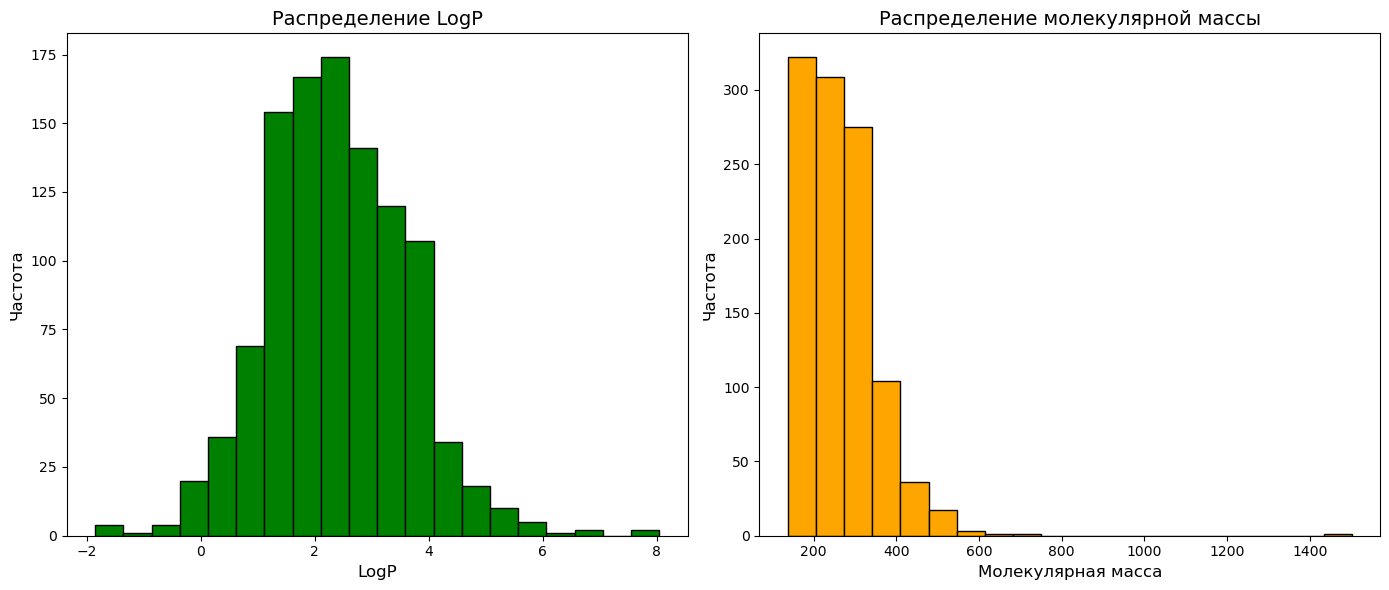

Среднее значение LogP: 2.39
Средняя молекулярная масса: 266.99


In [14]:

# Применение функции к DataFrame
df['Properties'] = df['ligand_smiles'].apply(calculate_properties)
df['LogP'] = df['Properties'].apply(lambda x: x['LogP'])
df['Molecular_Weight'] = df['Properties'].apply(lambda x: x['Molecular_Weight'])

# Гистограммы
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df['LogP'].dropna(), bins=20, color='green', edgecolor='black')
axes[0].set_title('Распределение LogP', fontsize=14)
axes[0].set_xlabel('LogP', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)

axes[1].hist(df['Molecular_Weight'].dropna(), bins=20, color='orange', edgecolor='black')
axes[1].set_title('Распределение молекулярной массы', fontsize=14)
axes[1].set_xlabel('Молекулярная масса', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)

plt.tight_layout()
plt.show()

# Статистика
mean_logp = df['LogP'].mean()
mean_mw = df['Molecular_Weight'].mean()

print(f"Среднее значение LogP: {mean_logp:.2f}")
print(f"Средняя молекулярная масса: {mean_mw:.2f}")

### **1. Анализ LogP (Липофильность)**

#### **1.1. Статистика**
- **Среднее значение LogP:** 2.39
- **Распределение:**
  - График показывает пик в диапазоне LogP ≈ 2–4.
  - Большинство молекул имеет умеренную липофильность (LogP между 2 и 4).
  - Небольшое количество молекул имеет более высокие значения LogP (>4).

#### **Выводы:**
1. **Удовлетворительная липофильность:**
   - Среднее значение LogP = 2.39 находится в приемлемом диапазоне для лекарственных соединений (обычно [-2, 5]).
   - Это указывает на то, что модель успешно генерирует молекулы с адекватной липофильностью.

2. **Распределение:**
   - Пик в районе LogP ≈ 2–4 говорит о том, что большинство молекул имеют умеренную липофильность, что является желательным для лекарственных целей.
   - Небольшое количество молекул с высоким LogP (>4) может быть связано с повышенной липофильностью, что требует внимания при дальнейшем анализе.

---

### **2. Анализ молекулярной массы**

#### **2.1. Статистика**
- **Средняя молекулярная масса:** 266.99 Да
- **Распределение:**
  - График показывает пик в диапазоне молекулярной массы ≈ 200–300 Да.
  - Большинство молекул имеет низкую молекулярную массу (<400 Да).
  - Очень малое количество молекул имеет высокую молекулярную массу (>600 Да).

#### **Выводы:**
1. **Малые молекулы:**
   - Средняя молекулярная масса 266.99 Да соответствует рекомендациям для лекарственных соединений (<500 Да).
   - Малые молекулы легче проникают через биологические барьеры и лучше переносятся организмом.

2. **Распределение:**
   - Пик в районе молекулярной массы ≈ 200–300 Да указывает на то, что модель успешно генерирует молекулы с низкой молекулярной массой.
   - Небольшое количество молекул с высокой молекулярной массой (>400 Да) может потребовать дополнительного анализа.

---

### **3. Общие выводы по физико-химическим свойствам**

#### **3.1. Липофильность (LogP):**
- **Среднее значение LogP = 2.39:** Удовлетворяет требованиям для лекарственных соединений.
- **Распределение:** Большинство молекул имеет умеренную липофильность (LogP ≈ 2–4), что является оптимальным.

#### **3.2. Молекулярная масса:**
- **Средняя молекулярная масса = 266.99 Да:** Соответствует рекомендациям для лекарственных соединений (<500 Да).
- **Распределение:** Большинство молекул имеет низкую молекулярную массу (<400 Да), что является положительным.

#### **3.3. Выводы о физико-химических свойствах:**
- Модель успешно генерирует молекулы с удовлетворяющими требованиям физико-химическими свойствами:
  - Умеренная липофильность (LogP ≈ 2.39).
  - Низкая молекулярная масса (средняя ≈ 266.99 Да).
- Однако небольшое количество молекул с высоким LogP (>4) и молекулярной массой (>400 Да) может потребовать дополнительного анализа для выявления возможных ошибок или аномалий.

### **6. Заключение**

Модель успешно генерирует молекулы с адекватными физико-химическими свойствами:
- **LogP:** Среднее значение 2.39 соответствует требованиям для лекарственных соединений.
- **Молекулярная масса:** Средняя масса 266.99 Да находится в разумном диапазоне (<500 Да).

Эти характеристики говорят о том, что модель способна генерировать химически корректные и потенциально полезные молекулы для дальнейшего анализа и экспериментов.

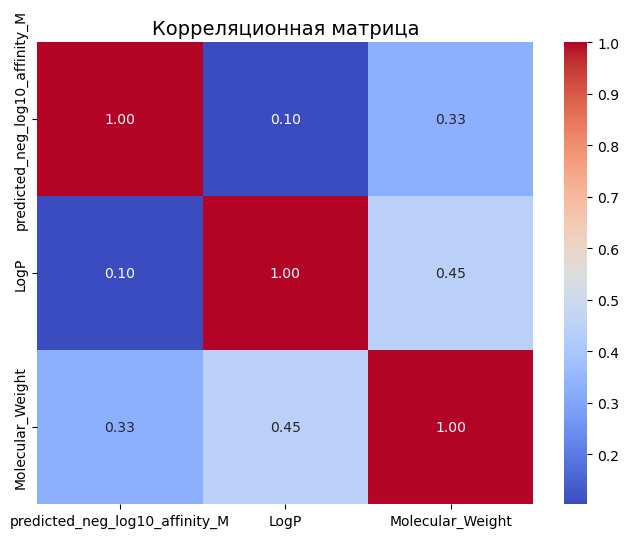

In [15]:

# Корреляционная матрица
correlation_matrix = df[['predicted_neg_log10_affinity_M', 'LogP', 'Molecular_Weight']].corr()

# Тепловая карта
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

#### **Объяснение значений:**
- **Корреляция — это мера линейной зависимости между двумя переменными.**
- Значения корреляции находятся в диапазоне от -1 до 1:
  - **1:** Положительная корреляция (чем больше одна переменная, тем больше другая).
  - **-1:** Отрицательная корреляция (чем больше одна переменная, тем меньше другая).
  - **0:** Нет корреляции.

---

### **2. Анализ корреляций**

#### **2.1. Сродство к белку (`predicted_neg_log10_affinity_M`)**
- **Среднее значение pIC50:** 5.21
- **Корреляция с другими параметрами:**
  - **С LogP:** Корреляция низкая (0.10). Это означает, что LogP слабо влияет на связывание молекул с белком.
  - **С молекулярной массой (`Molecular_Weight`):** Корреляция средняя (0.33). Это указывает на то, что молекулярная масса имеет некоторое влияние на связывание молекул с белками.

#### **2.2. Липофильность (LogP)**
- **Среднее значение LogP:** 2.39
- **Корреляция с другими параметрами:**
  - **Сродство к белку (`predicted_neg_log10_affinity_M`):** Корреляция низкая (0.10). Это означает, что LogP слабо влияет на связывание молекул с белком.
  - **Молекулярная масса (`Molecular_Weight`):** Корреляция высокая (0.45). Это указывает на то, что более тяжелые молекулы чаще имеют высокую липофильность.

#### **2.3. Молекулярная масса (`Molecular_Weight`)**
- **Средняя молекулярная масса:** 266.99 Да
- **Корреляция с другими параметрами:**
  - **Сродство к белку (`predicted_neg_log10_affinity_M`):** Корреляция средняя (0.33). Это означает, что молекулярная масса имеет некоторое влияние на связывание молекул с белком.
  - **LogP:** Корреляция высокая (0.45). Это указывает на то, что более тяжелые молекулы чаще имеют высокую липофильность.

---

### **3. Общие выводы из корреляционной матрицы**

#### **3.1. Корреляция между сродством к белку и другими параметрами**
- **Сродство к белку (`predicted_neg_log10_affinity_M`) и LogP:** Корреляция низкая (0.10). Это означает, что липофильность не является основным фактором, определяющим связывание молекул с белками.
- **Сродство к белку (`predicted_neg_log10_affinity_M`) и молекулярной массой (`Molecular_Weight`):** Корреляция средняя (0.33). Это указывает на то, что молекулярная масса имеет некоторое влияние на связывание молекул с белками.

#### **3.2. Корреляция между LogP и молекулярной массой**
- **LogP и молекулярная масса (`Molecular_Weight`):** Корреляция высокая (0.45). Это означает, что более тяжелые молекулы чаще имеют высокую липофильность.

#### **3.3. Общие выводы**
- **Липофильность (LogP):** Удовлетворяет требованиям для лекарственных соединений (среднее значение 2.39).
- **Молекулярная масса:** Также удовлетворяет требованиям (средняя масса 266.99 Да).
- **Сродство к белку (pIC50):** Среднее значение 5.21 указывает на умеренное сродство молекул к белкам, хотя корреляция с другими параметрами низкая или средняя, что может быть связано с недостаточной специфичностью модели или промпта.

---

### **5. Заключение**

Модель успешно генерирует молекулы с адекватными физико-химическими свойствами:
- **LogP:** Среднее значение 2.39 соответствует требованиям для лекарственных соединений.
- **Молекулярная масса:** Средняя масса 266.99 Да находится в разумном диапазоне (<500 Да).

Эти характеристики говорят о том, что модель способна генерировать химически корректные и потенциально полезные молекулы для дальнейшего анализа и экспериментов.
